## 模型选择、过拟合、欠拟合

当模型在训练集上更准确时，它在测试数据集上却不一定更准确。

- **训练数据集** 用于模型训练的数据集，对应的误差为**训练误差**。 
- **测试数据集** 用于测试训练后的模型性能的数据集，通常使用测试集的误差来近似**泛化误差**。

在模型选择的时候，就要选择使泛化误差最小的模型。

但从严格意义上讲，**测试集只能在所有超参数和模型选择参数选定后使用一次，不能使用测试数据对模型进行调参。** 

由于，无法从训练误差估计泛化误差，因此也不能只能训练数据集选择模型。 因此，通常在训练数据集和测试数据集外的数据进行模型选择，这部分数据称为验证数据集。 通常来说，可从给定的训练数据集中随机选择一小部分作为验证集，而将剩余的部分作为真正的训练集。

** K折交叉验证** 
把原始训练数据集随机的分割为$K$个不重合的子数据集，然后做$K$此模型训练和验证。　每一次，使用一个子数据集作为验证集，并使用其他的$K-1$子数据集来训练模型。　在这$K$次训练和验证中，每次用来验证模型的子数据集都不同。　最后，对这$K$次训练误差和验证误差分别求平均。

### 过拟合、欠拟合

给定的数据集，如果模型的复杂度过低，很容易出现欠拟合；模型的复杂度过高，很容易出现过拟合。　欠拟合，在训练时无法得到较低的训练误差；过拟合，则在测试集上误差远小于训练误差。　

影响欠拟合和过拟合的一个重要因素就是训练数据集的大小。　一般来说，如果训练样本中数据过少，特别市比模型参数量更少时，容易发生过拟合。　另外，泛化误差不会随着训练样本的增大而增加，因此在允许的范围内，总是希望训练数据集大一些。　

## 多项式函数拟合实验

生成一个人工数据集，给定样本特征$x$，使用如下三阶函数生成该样本的标签
$$
y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + \sigma
$$

### 矩阵乘法的分解
$$
 \begin{aligned} XW &= \left[\begin{array}{c}x_{11} & x_{12} & x_{13} \\ x_{21} &x_{22} &x_{23} \\ x_{31} & x_{32} &x_{33}\end{array}\right] \cdot \left [\begin{array}{c} w_{11} \\w_{21} \\ w_{31} \end{array}\right] \\
&=\left[\begin{array}{c}x_{11} \\ x_{21} \\ x_{31} \end{array} \right] \cdot [w_{11}] + \left[\begin{array}{c}x_{12} \\ x_{22} \\ x_{32} \end{array} \right] \cdot [w_{21}] + \left[\begin{array}{c}x_{13} \\ x_{23} \\ x_{33} \end{array} \right] \cdot [w_{31}]
\end{aligned}
$$

In [2]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 

n_train,n_test,true_w,true_b = 100,100,[1.2,3.4,5.6],5

# 生成数据集
features = torch.randn((n_train+ n_test,1))
poly_features = torch.cat((features,torch.pow(features,2),torch.pow(features,3)),1)

labels = (true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

print(features[:2],poly_features[:2],labels[:2])

tensor([[ 1.2856],
        [-0.6947]]) tensor([[ 1.2856,  1.6528,  2.1248],
        [-0.6947,  0.4826, -0.3353]]) tensor([24.0695,  3.9429])


In [3]:
def semilogy(x_vals,y_vals,x_label,y_label,x2_vals=None,y2_vals=None,legend=None):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals,y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals,y2_vals,linestyle=':')
        plt.legend(legend)

In [4]:
num_epochs = 100
loss = torch.nn.MSELoss()

def fit_and_plot(train_features,test_features,train_labels,test_labels):
    net = torch.nn.Linear(train_features.shape[-1],1)
    batch_size = min(10,train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    train_ls = []
    test_ls = []

    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y.view(-1,1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

        train_labels = train_labels.view(-1,1)
        test_labels = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features),train_labels).item())
        test_ls.append(loss(net(test_features),test_labels).item())
    print('final epoch:train loss',train_ls[-1],'test loss',test_ls[-1])
    semilogy(range(1,num_epochs+1),train_ls,'eopchs','loss',range(1,num_epochs+1),test_ls,['train','test'])
    print('weight:',net.weight.data,'\nbias:',net.bias.data)

final epoch:train loss 0.00010008071694755927 test loss 0.00012053922546328977
weight: tensor([[1.2037, 3.4005, 5.5992]]) 
bias: tensor([5.0007])


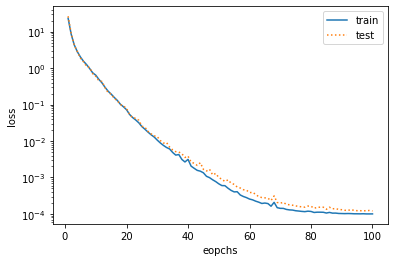

In [5]:
fit_and_plot(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])

## 线性函数拟合（欠拟合）

使用线性函数来拟合非线性模型，会出现欠拟合。模型的训练误差在迭代的早期下降后便很难在继续降低，在最训练误差保持在一个较大的值，不再下降.

final epoch:train loss 226.62135314941406 test loss 677.64404296875
weight: tensor([[18.9664]]) 
bias: tensor([8.9288])


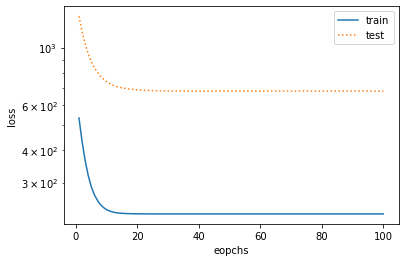

In [6]:
fit_and_plot(features[:n_train,:],features[n_train:,:],labels[:n_train],labels[n_train:])

## 训练样本不足（过拟合）
事实上，即便使用与数据生成模型同阶的三阶多项式函数，如果训练样本不足，该模型依然很容易过拟合。显然，训练样本过少了了，甚⾄至少于模型参数的数量量。这使模 型显得过于复杂，以⾄至于容易易被训练数据中的噪声影响。在迭代过程中，尽管训练误差较低，但是测试 数据集上的误差却很⾼高。这是典型的过拟合现象。

final epoch:train loss 0.10633235424757004 test loss 9.739349365234375
weight: tensor([[1.7816, 4.6718, 4.7165]]) 
bias: tensor([4.0462])


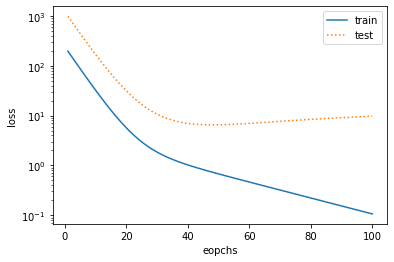

In [7]:
fit_and_plot(poly_features[0:2,:],poly_features[n_train:,:],labels[0:2],labels[n_train:])

## 总结
- 由于⽆无法从训练误差估计泛化误差，一味地降低训练误差并不不意味着泛化误差⼀一定会降低。机器器学习模型应关注降低泛化误差。
- 可以使⽤用验证数据集来进⾏行行模型选择。
- ⽋欠拟合指模型⽆无法得到较低的训练误差，过拟合指模型的训练误差远⼩小于它在测试数据集上的误差
- 应选择复杂度合适的模型并避免使⽤用过少的训练样本。